# **MAIN – Train Deep learning Model for face emotion detection (2025)**

Samuel Oliveira ([*oliveirasamuel.github.io*](https://github.com/oliveirasamuel5959))

---

## Importing the required libraries
---

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import cv2
import glob
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime
import json

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

2025-05-18 13:59:39.387115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 13:59:39.558512: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 13:59:40.727569: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 13:59:41.689164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747587582.555692    1040 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747587582.80

## The Training dataset: Facial Expression
---
* A set of emotions images
* face expression recognition dataset:
    * https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
    * 28709 images:
        * angry: 3995
        * disgust: 436
        * fear: 4097
        * happy: 7215
        * neutral: 4965
        * sad: 4830
        * surprise: 3171

In [62]:
# List of image labels
labels_list = []
# List of images filenames
images_list = []
def read_dataset(path, **kwargs):
    # define default data with image quantity
    defaultKwargs = {'angry': 2, 'fear': 2, 'happy': 2, 'neutral': 2, 'sad': 2}
    # update default to kwargs
    kwargs = {**defaultKwargs, **kwargs}
    # images sum
    sum_of_images = 0
    # iterate over each folder class names
    for idx, filename in enumerate(os.listdir(path)):
        # reset count
        count = 0
        # get num of images from params
        num_of_images = kwargs[filename]
        # iterate and get each image from path
        for image in tqdm(glob.glob(f"{path}/{filename}/*jpg")):
            if count >= num_of_images:
                break          
            # convert image to grayscale
            image = cv2.imread(image)
            # resize image to 224x224 for learning
            img_resized = cv2.resize(image, (224,224))
            # normalize image pixels values between 0 and 1
            # norm_img = cv2.normalize(gray_img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            # store images labels to labels_list
            labels_list.append(filename)
            # store images to images_list
            images_list.append(img_resized)
            # increment count to each num of images
            count += 1
            sum_of_images += 1
    # formatted string to print final result
    print(f'sum of images: {sum_of_images}')
    # conver lists to numpy array
    images_array = np.array(images_list)
    labels_array = np.array(labels_list)
    # return images, labels
    return images_array, labels_array  

### Visualizing Dataset Images

* Displaying the first N images from each class.
* This step is important for gaining an initial understanding of the dataset.

In [3]:
def dataset_visualization(X, y):
    # initial variables for figure
    nrows = 3
    ncols = 4

    # set initial parameters for figure
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 6), layout="constrained")

    # iterate through the images and class names
    for i, (image, filename) in enumerate(zip(X, y)):
        x, y = i//ncols, i%ncols
        # break before index out of range error
        if x == nrows:
            break
        # show images in grayscale
        ax[x, y].imshow(image, cmap='gray')
        ax[x, y].set_title(str(filename))

    # display grid of images
    fig.tight_layout()
    plt.show()

## Train Test Split Dataset

* Divide the dataset into X_train and y_train.
* This step is import to train the model and evaluate with new data.

In [4]:
# define X and y variables to store images and labels
# Total of 17256 images
# 2562
# 3345
# 2456
# 3265
# 2328
X, y = read_dataset(
    path='faces/train',
    angry=236,
    fear=125,
    happy=215,
    neutral=158,
    sad=146,
)

  3%|███▌                                                                                                                | 146/4830 [00:01<00:50, 92.93it/s]


sum of images: 880


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None, shuffle=True)

In [6]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
X_train.shape

(792, 224, 224, 3)

In [8]:
#X_train = X_train.reshape((X_train.shape[0], 224, 224, 3))
#X_test = X_test.reshape((X_test.shape[0], 224, 224, 3))

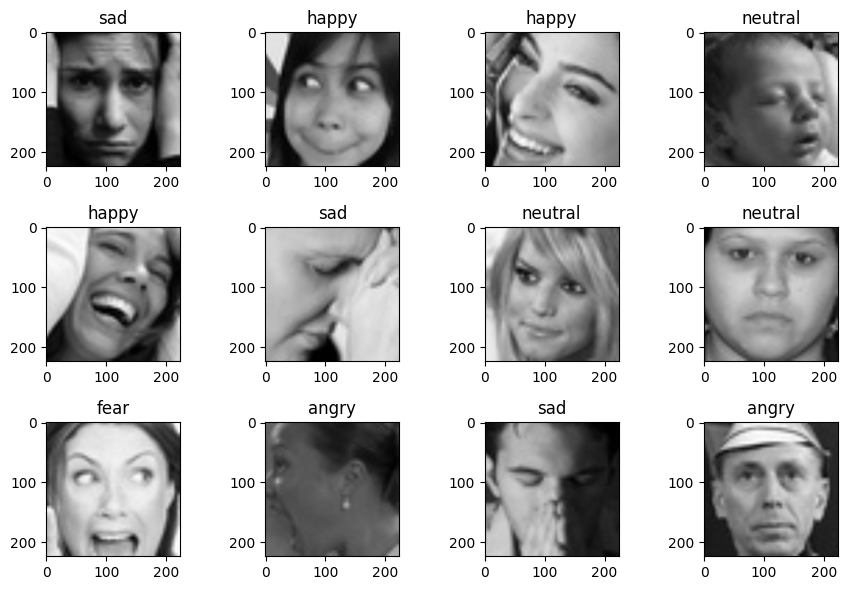

In [9]:
dataset_visualization(X_train, y_train)

## One Hot Encoding

In [13]:
y_train[:10]

array(['neutral', 'fear', 'neutral', 'neutral', 'neutral', 'neutral',
       'sad', 'angry', 'happy', 'neutral'], dtype='<U7')

In [14]:
y_test[:10]

array(['happy', 'happy', 'sad', 'happy', 'angry', 'fear', 'angry',
       'happy', 'neutral', 'neutral'], dtype='<U7')

In [15]:
# reshape the y_train array from 1D to 2D array
y_train_reshaped = y_train.reshape(-1, 1)
y_train_reshaped[:10]

array([['neutral'],
       ['fear'],
       ['neutral'],
       ['neutral'],
       ['neutral'],
       ['neutral'],
       ['sad'],
       ['angry'],
       ['happy'],
       ['neutral']], dtype='<U7')

In [17]:
# instantiate the OneHotEncoder classs
encoder = OneHotEncoder(sparse_output=False)
# transform 2D y_train to onehot encoding
y_train_onehot = encoder.fit_transform(y_train_reshaped)

In [18]:
y_test_onehot[:10]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

## Define Model

In [19]:
# Define the input layer specifying the shape
input_img = tf.keras.Input(shape=(48,48,1))

# Define the first convolution layer comming from input_img layer
conv1_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='valid', strides=1, activation='relu')(input_img)
pool1_1 = tf.keras.layers.MaxPool2D(pool_size=2, padding='valid')(conv1_1)

# Second convolution layer
conv2_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='valid', strides=1, activation='relu')(pool1_1)
pool2_1 = tf.keras.layers.MaxPool2D(pool_size=2, padding='valid')(conv2_1)

# Third convolution layer
conv3_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='valid', strides=1, activation='relu')(pool2_1)
pool3_1 = tf.keras.layers.MaxPool2D(pool_size=2, padding='valid')(conv3_1)

# Third convolution layer
conv4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', strides=1, activation='relu')(pool3_1)
pool4_1 = tf.keras.layers.MaxPool2D(pool_size=2, padding='valid')(conv4_1)

# Fully connected classifier
flatten = tf.keras.layers.Flatten()(pool4_1)
hidden1 = tf.keras.layers.Dense(units=2048, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001) )(flatten) # flatten dim after conv layer
dropout1 = tf.keras.layers.Dropout(0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(units=2048, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001) )(dropout1) # flatten dim after conv layer
dropout2 = tf.keras.layers.Dropout(0.5)(hidden2)
output = tf.keras.layers.Dense(units=5, activation='softmax')(dropout2) # 5 outputs

# Create the model using Model class from keras
model = tf.keras.models.Model(inputs=input_img, outputs=output)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 46, 46, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 2, 2, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2048)           │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,004,997 (19.09 MB)

 Trainable params: 5,004,997 (19.09 MB)

 Non-trainable params: 0 (0.00 B)

## Model Hyperparameters

In [15]:
MODEL_TOTAL_PARAMS = model.count_params()
MODEL_NAME = "Conv4"
print(MODEL_TOTAL_PARAMS)

INITIAL_LEARNING_RATE = 1E-4
EPOCHS = 200
BATCH_SIZE = 32

NameError: name 'model' is not defined

## Data Augumentation

In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    directory='faces/train',
    target_size=(48,48),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
)

NameError: name 'BATCH_SIZE' is not defined

In [15]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory='faces/validation',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 3083 images belonging to 5 classes.


## Model Training

In [22]:
# Generate Logs from training for validation
model_configuration = {
    "Model": MODEL_NAME,
    "Batch_size": BATCH_SIZE,
    "Epochs": EPOCHS,
    "Initial Learning rate": INITIAL_LEARNING_RATE,
    "Dropout": "Yes",
    "Regularization" : {
        "name": "L2",
        "penalty": 0.001,
    },
    "Conv2D": {
        "first_layer": 128,
        "second_layer": 256,
        "third_layer": 128,
        "fourth_layer": 64,
    },
    "Dense": {
        "first_layer": 2048,
        "second_layer": 2048,
    },
    "Total params": MODEL_TOTAL_PARAMS,
    "Total Time": f"{0}s"
}

print(json.dumps(model_configuration))

{"Model": "Conv4", "Batch_size": 32, "Epochs": 200, "Initial Learning rate": 0.0001, "Dropout": "Yes", "Regularization": {"name": "L2", "penalty": 0.001}, "Conv2D": {"first_layer": 128, "second_layer": 256, "third_layer": 128, "fourth_layer": 64}, "Dense": {"first_layer": 2048, "second_layer": 2048}, "Total params": 5004997, "Total Time": "0s"}


In [44]:
output_date = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(output_date)

2025-05-11T16:35:43Z


In [24]:
# Define a learning rate scheduler to adjust itself based on model val_loss performance
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.1,
    patience=20,
    min_lr=1e-5
)

# Model Hyperparameters
ADAM_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

# Model Compile
model.compile(
    optimizer=ADAM_OPTIMIZER,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

########## Model Checkpoints ################
# filepath to save best model tracking epochs
model_filepath = "saved_models/model-{epoch:02d}-{val_accuracy:.4f}.h5"
# define checkpoint list to the models
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# define earlystop to stop the model before overfitting
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')
callbacks_list = [earlystop, checkpoint, lr_scheduler]

start_time = time.time()
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
end_time = time.time()
# Update model configuration hyperparameters
model_configuration["Epochs"] = EPOCHS
model_configuration["Total Time"] = f"{round(end_time - start_time, 2)}s"

# history = model.fit(
#    X_train, 
#    y_train_onehot, 
#    epochs=EPOCHS, 
#    validation_data=(X_valid, y_valid_onehot),
#    verbose=1,
#    callbacks=callbacks_list
#)

Epoch 1/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2808 - loss: 2.5432
Epoch 1: val_accuracy improved from -inf to 0.28900, saving model to saved_models/model-01-0.2890.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 186s 237ms/step - accuracy: 0.2808 - loss: 2.5426 - val_accuracy: 0.2890 - val_loss: 1.6039 - learning_rate: 1.0000e-04
Epoch 2/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2946 - loss: 1.6051
Epoch 2: val_accuracy improved from 0.28900 to 0.30749, saving model to saved_models/model-02-0.3075.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 191s 245ms/step - accuracy: 0.2946 - loss: 1.6051 - val_accuracy: 0.3075 - val_loss: 1.5503 - learning_rate: 1.0000e-04
Epoch 3/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3017 - loss: 1.5740
Epoch 3: val_accuracy improved from 0.30749 to 0.35777, saving model to saved_models/model-03-0.3578.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 182s 233ms/step - accuracy: 0.3017 - loss: 1.5740 - val_accuracy: 0.3578 - val_loss: 1.5026 - learning_rate: 1.0000e-04
Epoch 4/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3223 - loss: 1.5464
Epoch 4: val_accuracy improved from 0.35777 to 0.41226, saving model to saved_models/model-04-0.4123.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 183s 235ms/step - accuracy: 0.3223 - loss: 1.5464 - val_accuracy: 0.4123 - val_loss: 1.4077 - learning_rate: 1.0000e-04
Epoch 5/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.3601 - loss: 1.4886
Epoch 5: val_accuracy improved from 0.41226 to 0.43951, saving model to saved_models/model-05-0.4395.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 184s 236ms/step - accuracy: 0.3601 - loss: 1.4886 - val_accuracy: 0.4395 - val_loss: 1.3410 - learning_rate: 1.0000e-04
Epoch 6/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.3781 - loss: 1.4497
Epoch 6: val_accuracy did not improve from 0.43951
780/780 ━━━━━━━━━━━━━━━━━━━━ 184s 235ms/step - accuracy: 0.3781 - loss: 1.4496 - val_accuracy: 0.4191 - val_loss: 1.3317 - learning_rate: 1.0000e-04
Epoch 7/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4044 - loss: 1.4057
Epoch 7: val_accuracy did not improve from 0.43951
780/780 ━━━━━━━━━━━━━━━━━━━━ 185s 237ms/step - accuracy: 0.4044 - loss: 1.4057 - val_accuracy: 0.4317 - val_loss: 1.3134 - learning_rate: 1.0000e-04
Epoch 8/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4205 - loss: 1.3809
Epoch 8: val_accuracy improved from 0.43951 to 0.46675, saving model to saved_models/model-08-0.4668.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 186s 238ms/step - accuracy: 0.4205 - loss: 1.3809 - val_accuracy: 0.4668 - val_loss: 1.2791 - learning_rate: 1.0000e-04
Epoch 9/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4302 - loss: 1.3600
Epoch 9: val_accuracy improved from 0.46675 to 0.50276, saving model to saved_models/model-09-0.5028.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 189s 242ms/step - accuracy: 0.4302 - loss: 1.3599 - val_accuracy: 0.5028 - val_loss: 1.2231 - learning_rate: 1.0000e-04
Epoch 10/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4402 - loss: 1.3445
Epoch 10: val_accuracy did not improve from 0.50276
780/780 ━━━━━━━━━━━━━━━━━━━━ 183s 234ms/step - accuracy: 0.4402 - loss: 1.3445 - val_accuracy: 0.4788 - val_loss: 1.2366 - learning_rate: 1.0000e-04
Epoch 11/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4458 - loss: 1.3291
Epoch 11: val_accuracy did not improve from 0.50276
780/780 ━━━━━━━━━━━━━━━━━━━━ 181s 232ms/step - accuracy: 0.4458 - loss: 1.3291 - val_accuracy: 0.4979 - val_loss: 1.2196 - learning_rate: 1.0000e-04
Epoch 12/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4610 - loss: 1.3179
Epoch 12: val_accuracy did not improve from 0.50276
780/780 ━━━━━━━━━━━━━━━━━━━━ 186s 239ms/step - accuracy: 0.4610 - loss: 1.3179 - val_accuracy: 0.4768 - val_loss: 1.2378 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 183s 234ms/step - accuracy: 0.4673 - loss: 1.2995 - val_accuracy: 0.5316 - val_loss: 1.1685 - learning_rate: 1.0000e-04
Epoch 14/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4717 - loss: 1.2907
Epoch 14: val_accuracy did not improve from 0.53163
780/780 ━━━━━━━━━━━━━━━━━━━━ 185s 237ms/step - accuracy: 0.4717 - loss: 1.2907 - val_accuracy: 0.5264 - val_loss: 1.1700 - learning_rate: 1.0000e-04
Epoch 15/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4792 - loss: 1.2673
Epoch 15: val_accuracy improved from 0.53163 to 0.53941, saving model to saved_models/model-15-0.5394.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 187s 239ms/step - accuracy: 0.4792 - loss: 1.2673 - val_accuracy: 0.5394 - val_loss: 1.1590 - learning_rate: 1.0000e-04
Epoch 16/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.4818 - loss: 1.2656
Epoch 16: val_accuracy did not improve from 0.53941
780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 230ms/step - accuracy: 0.4818 - loss: 1.2656 - val_accuracy: 0.5355 - val_loss: 1.1574 - learning_rate: 1.0000e-04
Epoch 17/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4846 - loss: 1.2655
Epoch 17: val_accuracy improved from 0.53941 to 0.55368, saving model to saved_models/model-17-0.5537.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 231ms/step - accuracy: 0.4846 - loss: 1.2654 - val_accuracy: 0.5537 - val_loss: 1.1255 - learning_rate: 1.0000e-04
Epoch 18/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4958 - loss: 1.2485
Epoch 18: val_accuracy did not improve from 0.55368
780/780 ━━━━━━━━━━━━━━━━━━━━ 183s 235ms/step - accuracy: 0.4958 - loss: 1.2485 - val_accuracy: 0.5534 - val_loss: 1.1300 - learning_rate: 1.0000e-04
Epoch 19/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4976 - loss: 1.2424
Epoch 19: val_accuracy improved from 0.55368 to 0.56082, saving model to saved_models/model-19-0.5608.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 182s 233ms/step - accuracy: 0.4976 - loss: 1.2424 - val_accuracy: 0.5608 - val_loss: 1.1243 - learning_rate: 1.0000e-04
Epoch 20/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5002 - loss: 1.2306
Epoch 20: val_accuracy did not improve from 0.56082
780/780 ━━━━━━━━━━━━━━━━━━━━ 182s 233ms/step - accuracy: 0.5002 - loss: 1.2306 - val_accuracy: 0.5443 - val_loss: 1.1314 - learning_rate: 1.0000e-04
Epoch 21/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5079 - loss: 1.2217
Epoch 21: val_accuracy did not improve from 0.56082
780/780 ━━━━━━━━━━━━━━━━━━━━ 182s 233ms/step - accuracy: 0.5079 - loss: 1.2217 - val_accuracy: 0.5375 - val_loss: 1.1671 - learning_rate: 1.0000e-04
Epoch 22/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5122 - loss: 1.2134
Epoch 22: val_accuracy improved from 0.56082 to 0.56147, saving model to saved_models/model-22-0.5615.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 225ms/step - accuracy: 0.5122 - loss: 1.2134 - val_accuracy: 0.5615 - val_loss: 1.1012 - learning_rate: 1.0000e-04
Epoch 23/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5168 - loss: 1.1998
Epoch 23: val_accuracy improved from 0.56147 to 0.56244, saving model to saved_models/model-23-0.5624.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 181s 232ms/step - accuracy: 0.5168 - loss: 1.1998 - val_accuracy: 0.5624 - val_loss: 1.1148 - learning_rate: 1.0000e-04
Epoch 24/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5257 - loss: 1.1905
Epoch 24: val_accuracy improved from 0.56244 to 0.57898, saving model to saved_models/model-24-0.5790.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 181s 232ms/step - accuracy: 0.5257 - loss: 1.1905 - val_accuracy: 0.5790 - val_loss: 1.0786 - learning_rate: 1.0000e-04
Epoch 25/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5316 - loss: 1.1869
Epoch 25: val_accuracy did not improve from 0.57898
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 230ms/step - accuracy: 0.5316 - loss: 1.1869 - val_accuracy: 0.5722 - val_loss: 1.0953 - learning_rate: 1.0000e-04
Epoch 26/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5346 - loss: 1.1783
Epoch 26: val_accuracy improved from 0.57898 to 0.59260, saving model to saved_models/model-26-0.5926.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 184s 236ms/step - accuracy: 0.5346 - loss: 1.1783 - val_accuracy: 0.5926 - val_loss: 1.0457 - learning_rate: 1.0000e-04
Epoch 27/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5319 - loss: 1.1770
Epoch 27: val_accuracy did not improve from 0.59260
780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 231ms/step - accuracy: 0.5319 - loss: 1.1770 - val_accuracy: 0.5926 - val_loss: 1.0710 - learning_rate: 1.0000e-04
Epoch 28/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5408 - loss: 1.1551
Epoch 28: val_accuracy did not improve from 0.59260
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - accuracy: 0.5408 - loss: 1.1551 - val_accuracy: 0.5874 - val_loss: 1.0738 - learning_rate: 1.0000e-04
Epoch 29/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5427 - loss: 1.1541
Epoch 29: val_accuracy improved from 0.59260 to 0.59520, saving model to saved_models/model-29-0.5952.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 182s 234ms/step - accuracy: 0.5427 - loss: 1.1541 - val_accuracy: 0.5952 - val_loss: 1.0432 - learning_rate: 1.0000e-04
Epoch 30/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5524 - loss: 1.1436
Epoch 30: val_accuracy did not improve from 0.59520
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 230ms/step - accuracy: 0.5524 - loss: 1.1436 - val_accuracy: 0.5780 - val_loss: 1.0545 - learning_rate: 1.0000e-04
Epoch 31/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5460 - loss: 1.1496
Epoch 31: val_accuracy improved from 0.59520 to 0.59844, saving model to saved_models/model-31-0.5984.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 184s 236ms/step - accuracy: 0.5460 - loss: 1.1496 - val_accuracy: 0.5984 - val_loss: 1.0325 - learning_rate: 1.0000e-04
Epoch 32/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5534 - loss: 1.1309
Epoch 32: val_accuracy did not improve from 0.59844
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - accuracy: 0.5534 - loss: 1.1309 - val_accuracy: 0.5949 - val_loss: 1.0436 - learning_rate: 1.0000e-04
Epoch 33/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5558 - loss: 1.1353
Epoch 33: val_accuracy improved from 0.59844 to 0.60331, saving model to saved_models/model-33-0.6033.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 230ms/step - accuracy: 0.5558 - loss: 1.1353 - val_accuracy: 0.6033 - val_loss: 1.0246 - learning_rate: 1.0000e-04
Epoch 34/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5584 - loss: 1.1162
Epoch 34: val_accuracy did not improve from 0.60331
780/780 ━━━━━━━━━━━━━━━━━━━━ 178s 228ms/step - accuracy: 0.5584 - loss: 1.1162 - val_accuracy: 0.6020 - val_loss: 1.0168 - learning_rate: 1.0000e-04
Epoch 35/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5602 - loss: 1.1200
Epoch 35: val_accuracy improved from 0.60331 to 0.62731, saving model to saved_models/model-35-0.6273.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 183s 234ms/step - accuracy: 0.5602 - loss: 1.1200 - val_accuracy: 0.6273 - val_loss: 0.9845 - learning_rate: 1.0000e-04
Epoch 36/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5682 - loss: 1.1055
Epoch 36: val_accuracy did not improve from 0.62731
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - accuracy: 0.5682 - loss: 1.1055 - val_accuracy: 0.5916 - val_loss: 1.0452 - learning_rate: 1.0000e-04
Epoch 37/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5646 - loss: 1.1155
Epoch 37: val_accuracy did not improve from 0.62731
780/780 ━━━━━━━━━━━━━━━━━━━━ 177s 227ms/step - accuracy: 0.5646 - loss: 1.1155 - val_accuracy: 0.6030 - val_loss: 1.0277 - learning_rate: 1.0000e-04
Epoch 38/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5630 - loss: 1.1142
Epoch 38: val_accuracy did not improve from 0.62731
780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 231ms/step - accuracy: 0.5630 - loss: 1.1142 - val_accuracy: 0.6114 - val_loss: 1.0030 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 230ms/step - accuracy: 0.5882 - loss: 1.0611 - val_accuracy: 0.6354 - val_loss: 0.9496 - learning_rate: 1.0000e-04
Epoch 51/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5922 - loss: 1.0500
Epoch 51: val_accuracy did not improve from 0.63542
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - accuracy: 0.5922 - loss: 1.0500 - val_accuracy: 0.6182 - val_loss: 0.9774 - learning_rate: 1.0000e-04
Epoch 52/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5885 - loss: 1.0574
Epoch 52: val_accuracy did not improve from 0.63542
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - accuracy: 0.5885 - loss: 1.0574 - val_accuracy: 0.6153 - val_loss: 0.9933 - learning_rate: 1.0000e-04
Epoch 53/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5921 - loss: 1.0412
Epoch 53: val_accuracy did not improve from 0.63542
780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 225ms/step - accuracy: 0.5921 - loss: 1.0412 - val_accuracy: 0.6302 - val_loss: 0.9676 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 182s 233ms/step - accuracy: 0.5981 - loss: 1.0365 - val_accuracy: 0.6390 - val_loss: 0.9533 - learning_rate: 1.0000e-04
Epoch 59/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6028 - loss: 1.0305
Epoch 59: val_accuracy did not improve from 0.63899
780/780 ━━━━━━━━━━━━━━━━━━━━ 178s 228ms/step - accuracy: 0.6027 - loss: 1.0305 - val_accuracy: 0.6289 - val_loss: 0.9611 - learning_rate: 1.0000e-04
Epoch 60/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6005 - loss: 1.0342
Epoch 60: val_accuracy improved from 0.63899 to 0.64450, saving model to saved_models/model-60-0.6445.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 225ms/step - accuracy: 0.6005 - loss: 1.0342 - val_accuracy: 0.6445 - val_loss: 0.9391 - learning_rate: 1.0000e-04
Epoch 61/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5990 - loss: 1.0354
Epoch 61: val_accuracy did not improve from 0.64450
780/780 ━━━━━━━━━━━━━━━━━━━━ 179s 230ms/step - accuracy: 0.5990 - loss: 1.0354 - val_accuracy: 0.6095 - val_loss: 1.0038 - learning_rate: 1.0000e-04
Epoch 62/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6040 - loss: 1.0241
Epoch 62: val_accuracy did not improve from 0.64450
780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 231ms/step - accuracy: 0.6040 - loss: 1.0241 - val_accuracy: 0.6370 - val_loss: 0.9442 - learning_rate: 1.0000e-04
Epoch 63/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5996 - loss: 1.0220
Epoch 63: val_accuracy did not improve from 0.64450
780/780 ━━━━━━━━━━━━━━━━━━━━ 171s 219ms/step - accuracy: 0.5996 - loss: 1.0220 - val_accuracy: 0.6205 - val_loss: 0.9560 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 230ms/step - accuracy: 0.6097 - loss: 1.0059 - val_accuracy: 0.6474 - val_loss: 0.9188 - learning_rate: 1.0000e-04
Epoch 72/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6124 - loss: 1.0038
Epoch 72: val_accuracy did not improve from 0.64742
780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 225ms/step - accuracy: 0.6124 - loss: 1.0038 - val_accuracy: 0.6208 - val_loss: 0.9655 - learning_rate: 1.0000e-04
Epoch 73/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6190 - loss: 0.9973
Epoch 73: val_accuracy did not improve from 0.64742
780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 225ms/step - accuracy: 0.6190 - loss: 0.9973 - val_accuracy: 0.6351 - val_loss: 0.9529 - learning_rate: 1.0000e-04
Epoch 74/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6110 - loss: 1.0041
Epoch 74: val_accuracy did not improve from 0.64742
780/780 ━━━━━━━━━━━━━━━━━━━━ 174s 223ms/step - accuracy: 0.6110 - loss: 1.0041 - val_accuracy: 0.6387 - val_loss: 0.9315 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 224ms/step - accuracy: 0.6135 - loss: 1.0025 - val_accuracy: 0.6520 - val_loss: 0.9147 - learning_rate: 1.0000e-04
Epoch 76/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6218 - loss: 0.9885
Epoch 76: val_accuracy did not improve from 0.65196
780/780 ━━━━━━━━━━━━━━━━━━━━ 178s 228ms/step - accuracy: 0.6218 - loss: 0.9885 - val_accuracy: 0.6455 - val_loss: 0.9225 - learning_rate: 1.0000e-04
Epoch 77/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6090 - loss: 1.0124
Epoch 77: val_accuracy did not improve from 0.65196
780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 231ms/step - accuracy: 0.6090 - loss: 1.0124 - val_accuracy: 0.6322 - val_loss: 0.9388 - learning_rate: 1.0000e-04
Epoch 78/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6172 - loss: 0.9957
Epoch 78: val_accuracy did not improve from 0.65196
780/780 ━━━━━━━━━━━━━━━━━━━━ 173s 221ms/step - accuracy: 0.6172 - loss: 0.9957 - val_accuracy: 0.6500 - val_loss: 0.9206 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 169s 217ms/step - accuracy: 0.6185 - loss: 0.9785 - val_accuracy: 0.6542 - val_loss: 0.9076 - learning_rate: 1.0000e-04
Epoch 84/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6270 - loss: 0.9769
Epoch 84: val_accuracy did not improve from 0.65423
780/780 ━━━━━━━━━━━━━━━━━━━━ 180s 230ms/step - accuracy: 0.6270 - loss: 0.9769 - val_accuracy: 0.6497 - val_loss: 0.9140 - learning_rate: 1.0000e-04
Epoch 85/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6240 - loss: 0.9797
Epoch 85: val_accuracy did not improve from 0.65423
780/780 ━━━━━━━━━━━━━━━━━━━━ 174s 223ms/step - accuracy: 0.6240 - loss: 0.9797 - val_accuracy: 0.6526 - val_loss: 0.9143 - learning_rate: 1.0000e-04
Epoch 86/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6292 - loss: 0.9681
Epoch 86: val_accuracy did not improve from 0.65423
780/780 ━━━━━━━━━━━━━━━━━━━━ 174s 223ms/step - accuracy: 0.6292 - loss: 0.9681 - val_accuracy: 0.6510 - val_loss: 0.9128 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 174s 223ms/step - accuracy: 0.6277 - loss: 0.9722 - val_accuracy: 0.6552 - val_loss: 0.9174 - learning_rate: 1.0000e-04
Epoch 88/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6251 - loss: 0.9755
Epoch 88: val_accuracy did not improve from 0.65521
780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 225ms/step - accuracy: 0.6251 - loss: 0.9755 - val_accuracy: 0.6435 - val_loss: 0.9240 - learning_rate: 1.0000e-04
Epoch 89/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6277 - loss: 0.9662
Epoch 89: val_accuracy did not improve from 0.65521
780/780 ━━━━━━━━━━━━━━━━━━━━ 171s 219ms/step - accuracy: 0.6277 - loss: 0.9662 - val_accuracy: 0.6439 - val_loss: 0.9471 - learning_rate: 1.0000e-04
Epoch 90/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6283 - loss: 0.9766
Epoch 90: val_accuracy did not improve from 0.65521
780/780 ━━━━━━━━━━━━━━━━━━━━ 173s 222ms/step - accuracy: 0.6283 - loss: 0.9766 - val_accuracy: 0.6490 - val_loss: 0.9142 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.6353 - loss: 0.9517 - val_accuracy: 0.6572 - val_loss: 0.9052 - learning_rate: 1.0000e-04
Epoch 96/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6306 - loss: 0.9571
Epoch 96: val_accuracy did not improve from 0.65715
780/780 ━━━━━━━━━━━━━━━━━━━━ 178s 228ms/step - accuracy: 0.6306 - loss: 0.9571 - val_accuracy: 0.6542 - val_loss: 0.8968 - learning_rate: 1.0000e-04
Epoch 97/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6341 - loss: 0.9568
Epoch 97: val_accuracy did not improve from 0.65715
780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 224ms/step - accuracy: 0.6341 - loss: 0.9568 - val_accuracy: 0.6341 - val_loss: 0.9288 - learning_rate: 1.0000e-04
Epoch 98/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6300 - loss: 0.9585
Epoch 98: val_accuracy did not improve from 0.65715
780/780 ━━━━━━━━━━━━━━━━━━━━ 171s 219ms/step - accuracy: 0.6300 - loss: 0.9585 - val_accuracy: 0.6400 - val_loss: 0.9389 - lear

780/780 ━━━━━━━━━━━━━━━━━━━━ 178s 228ms/step - accuracy: 0.6366 - loss: 0.9526 - val_accuracy: 0.6591 - val_loss: 0.9035 - learning_rate: 1.0000e-04
Epoch 100/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6384 - loss: 0.9471
Epoch 100: val_accuracy did not improve from 0.65910
780/780 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.6384 - loss: 0.9471 - val_accuracy: 0.6516 - val_loss: 0.9057 - learning_rate: 1.0000e-04
Epoch 101/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6363 - loss: 0.9488
Epoch 101: val_accuracy did not improve from 0.65910
780/780 ━━━━━━━━━━━━━━━━━━━━ 177s 227ms/step - accuracy: 0.6363 - loss: 0.9488 - val_accuracy: 0.6591 - val_loss: 0.8937 - learning_rate: 1.0000e-04
Epoch 102/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6380 - loss: 0.9444
Epoch 102: val_accuracy did not improve from 0.65910
780/780 ━━━━━━━━━━━━━━━━━━━━ 177s 227ms/step - accuracy: 0.6380 - loss: 0.9444 - val_accuracy: 0.6516 - val_loss: 0.9225 

780/780 ━━━━━━━━━━━━━━━━━━━━ 177s 227ms/step - accuracy: 0.6421 - loss: 0.9461 - val_accuracy: 0.6633 - val_loss: 0.8817 - learning_rate: 1.0000e-04
Epoch 109/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6492 - loss: 0.9299
Epoch 109: val_accuracy did not improve from 0.66331
780/780 ━━━━━━━━━━━━━━━━━━━━ 170s 218ms/step - accuracy: 0.6492 - loss: 0.9299 - val_accuracy: 0.6546 - val_loss: 0.8864 - learning_rate: 1.0000e-04
Epoch 110/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6416 - loss: 0.9383
Epoch 110: val_accuracy did not improve from 0.66331
780/780 ━━━━━━━━━━━━━━━━━━━━ 173s 222ms/step - accuracy: 0.6416 - loss: 0.9383 - val_accuracy: 0.6461 - val_loss: 0.9217 - learning_rate: 1.0000e-04
Epoch 111/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6456 - loss: 0.9379
Epoch 111: val_accuracy did not improve from 0.66331
780/780 ━━━━━━━━━━━━━━━━━━━━ 174s 223ms/step - accuracy: 0.6456 - loss: 0.9379 - val_accuracy: 0.6539 - val_loss: 0.9090 

780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 225ms/step - accuracy: 0.6455 - loss: 0.9258 - val_accuracy: 0.6656 - val_loss: 0.8745 - learning_rate: 1.0000e-04
Epoch 118/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6540 - loss: 0.9136
Epoch 118: val_accuracy did not improve from 0.66559
780/780 ━━━━━━━━━━━━━━━━━━━━ 177s 226ms/step - accuracy: 0.6540 - loss: 0.9136 - val_accuracy: 0.6559 - val_loss: 0.9144 - learning_rate: 1.0000e-04
Epoch 119/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6477 - loss: 0.9248
Epoch 119: val_accuracy improved from 0.66559 to 0.66688, saving model to saved_models/model-119-0.6669.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 173s 222ms/step - accuracy: 0.6477 - loss: 0.9248 - val_accuracy: 0.6669 - val_loss: 0.8931 - learning_rate: 1.0000e-04
Epoch 120/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6472 - loss: 0.9267
Epoch 120: val_accuracy improved from 0.66688 to 0.67078, saving model to saved_models/model-120-0.6708.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 173s 222ms/step - accuracy: 0.6472 - loss: 0.9267 - val_accuracy: 0.6708 - val_loss: 0.8765 - learning_rate: 1.0000e-04
Epoch 121/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6470 - loss: 0.9202
Epoch 121: val_accuracy improved from 0.67078 to 0.67207, saving model to saved_models/model-121-0.6721.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 224ms/step - accuracy: 0.6470 - loss: 0.9202 - val_accuracy: 0.6721 - val_loss: 0.8872 - learning_rate: 1.0000e-04
Epoch 122/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6533 - loss: 0.9147
Epoch 122: val_accuracy did not improve from 0.67207
780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 226ms/step - accuracy: 0.6533 - loss: 0.9147 - val_accuracy: 0.6614 - val_loss: 0.8990 - learning_rate: 1.0000e-04
Epoch 123/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6534 - loss: 0.9137
Epoch 123: val_accuracy did not improve from 0.67207
780/780 ━━━━━━━━━━━━━━━━━━━━ 172s 220ms/step - accuracy: 0.6534 - loss: 0.9137 - val_accuracy: 0.6546 - val_loss: 0.9151 - learning_rate: 1.0000e-04
Epoch 124/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6538 - loss: 0.9160
Epoch 124: val_accuracy did not improve from 0.67207
780/780 ━━━━━━━━━━━━━━━━━━━━ 174s 222ms/step - accuracy: 0.6538 - loss: 0.9160 - val_accuracy: 0.6623 - val_loss: 0.8939 

780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 226ms/step - accuracy: 0.6607 - loss: 0.9010 - val_accuracy: 0.6779 - val_loss: 0.8667 - learning_rate: 1.0000e-04
Epoch 139/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6570 - loss: 0.8981
Epoch 139: val_accuracy did not improve from 0.67791
780/780 ━━━━━━━━━━━━━━━━━━━━ 166s 213ms/step - accuracy: 0.6570 - loss: 0.8981 - val_accuracy: 0.6604 - val_loss: 0.8953 - learning_rate: 1.0000e-04
Epoch 140/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6528 - loss: 0.9062
Epoch 140: val_accuracy did not improve from 0.67791
780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 224ms/step - accuracy: 0.6528 - loss: 0.9062 - val_accuracy: 0.6604 - val_loss: 0.8967 - learning_rate: 1.0000e-04
Epoch 141/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6590 - loss: 0.8978
Epoch 141: val_accuracy did not improve from 0.67791
780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 225ms/step - accuracy: 0.6590 - loss: 0.8978 - val_accuracy: 0.6627 - val_loss: 0.8886 

780/780 ━━━━━━━━━━━━━━━━━━━━ 173s 221ms/step - accuracy: 0.6667 - loss: 0.8867 - val_accuracy: 0.6789 - val_loss: 0.8624 - learning_rate: 1.0000e-04
Epoch 151/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6698 - loss: 0.8782
Epoch 151: val_accuracy did not improve from 0.67888
780/780 ━━━━━━━━━━━━━━━━━━━━ 176s 226ms/step - accuracy: 0.6698 - loss: 0.8782 - val_accuracy: 0.6614 - val_loss: 0.9037 - learning_rate: 1.0000e-04
Epoch 152/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6667 - loss: 0.8867
Epoch 152: val_accuracy did not improve from 0.67888
780/780 ━━━━━━━━━━━━━━━━━━━━ 166s 213ms/step - accuracy: 0.6667 - loss: 0.8867 - val_accuracy: 0.6653 - val_loss: 0.8765 - learning_rate: 1.0000e-04
Epoch 153/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6608 - loss: 0.8851
Epoch 153: val_accuracy did not improve from 0.67888
780/780 ━━━━━━━━━━━━━━━━━━━━ 177s 227ms/step - accuracy: 0.6608 - loss: 0.8851 - val_accuracy: 0.6529 - val_loss: 0.9078 

780/780 ━━━━━━━━━━━━━━━━━━━━ 173s 222ms/step - accuracy: 0.6661 - loss: 0.8711 - val_accuracy: 0.6828 - val_loss: 0.8621 - learning_rate: 1.0000e-04
Epoch 155/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6635 - loss: 0.8848
Epoch 155: val_accuracy did not improve from 0.68278
780/780 ━━━━━━━━━━━━━━━━━━━━ 175s 225ms/step - accuracy: 0.6635 - loss: 0.8848 - val_accuracy: 0.6737 - val_loss: 0.8626 - learning_rate: 1.0000e-04
Epoch 156/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6656 - loss: 0.8765
Epoch 156: val_accuracy did not improve from 0.68278

Epoch 156: ReduceLROnPlateau reducing learning rate to 1e-05.
780/780 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.6656 - loss: 0.8765 - val_accuracy: 0.6646 - val_loss: 0.8679 - learning_rate: 1.0000e-04
Epoch 157/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6794 - loss: 0.8608
Epoch 157: val_accuracy did not improve from 0.68278
780/780 ━━━━━━━━━━━━━━━━━━━━ 174s 223ms/step - accuracy: 0

### Training History

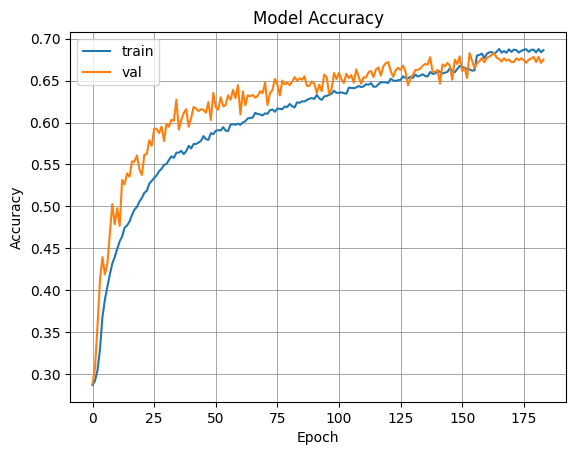

In [33]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.legend(['train', 'val'], loc='upper left')

# path
path = f"logs/{output_date}_model_training_results"
if not os.path.isdir(path):
    os.makedirs(path)
    plt.savefig(f"{path}/acc_plot.jpg")
    plt.show()

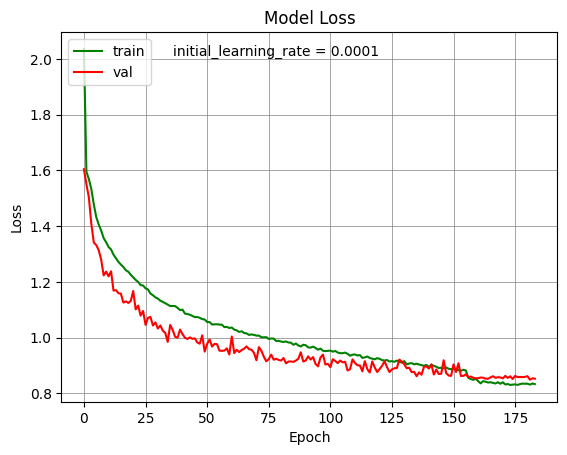

In [32]:
# summarize history for loss
plt.plot(history.history['loss'], color='green')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.figtext(0.30, 0.83, f'initial_learning_rate = {INITIAL_LEARNING_RATE}')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.legend(['train', 'val'], loc='upper left')

# path
path = f"logs/{output_date}_model_training_results"
if os.path.isdir(path):
    plt.savefig(f"{path}/loss_plot.jpg")
    plt.show()

### Saving model configuration and hyperparameters values to json file

In [28]:
with open(f"{path}/{output_date}_model_configuration.json", "w") as json_file:
    json.dump(model_configuration, json_file)

In [199]:
json_string = model.to_json()
with open(f"{path}/{output_date}_model_architecture.json", "w") as model_architecture_json:
    model_architecture_json.write(json_string)

---

# Transfer Learning MobilenetV2

In [40]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2()

In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [42]:
base_input = base_model.layers[1].input
base_input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_328>

In [43]:
base_output = base_model.layers[-2].output
base_output

<KerasTensor shape=(None, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_482>

In [44]:
x = tf.keras.layers.Dense(units=512, activation='relu')(base_output)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
prediction = tf.keras.layers.Dense(units=5, activation='softmax')(x) # classification layers for 5 classes

In [45]:
# x = base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(units=2048, activation='relu')(x)
# x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
# prediction = tf.keras.layers.Dense(units=5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_input, outputs=prediction)

In [46]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,469 (11.62 MB)

 Trainable params: 3,012,357 (11.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [47]:
# Set the last trainable layers to false 
# for layers in model.layers[:-4]:
    #layers.trainable = False

In [48]:
#model.summary()

In [49]:
MODEL_TOTAL_PARAMS = model.count_params()
MODEL_NAME = "MobileNetV2 Transfer Learning"
print(MODEL_TOTAL_PARAMS)
INITIAL_LEARNING_RATE = 1E-3
EPOCHS = 50
BATCH_SIZE = 32

3046469


In [50]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    directory='faces/train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
)

Found 24951 images belonging to 5 classes.


In [51]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory='faces/validation',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 3083 images belonging to 5 classes.


In [52]:
# Generate Logs from training for validation
model_configuration = {
    "Model": MODEL_NAME,
    "Device": "cpu",
    "Batch_size": BATCH_SIZE,
    "Epochs": EPOCHS,
    "Learning rate": INITIAL_LEARNING_RATE,
    "Dropout": "Yes",
    "Dense": {
        "first_layer": 512,
        "second_layer": 256,
    },
    "Total params": MODEL_TOTAL_PARAMS,
    "Total Time": f"{0}s"
}

print(json.dumps(model_configuration))

{"Model": "MobileNetV2 Transfer Learning", "Device": "cpu", "Batch_size": 32, "Epochs": 50, "Learning rate": 0.001, "Dropout": "Yes", "Dense": {"first_layer": 512, "second_layer": 256}, "Total params": 3046469, "Total Time": "0s"}


---

In [53]:
# Define a learning rate scheduler to adjust itself based on model val_loss performance
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

# Model Hyperparameters
ADAM_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

# Model Compile
model.compile(
    optimizer=ADAM_OPTIMIZER,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

########## Model Checkpoints ################
# filepath to save best model tracking epochs
model_filepath = "saved_models/model-{epoch:02d}-{val_accuracy:.4f}.h5"
# define checkpoint list to the models
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# define earlystop to stop the model before overfitting
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
callbacks_list = [earlystop, checkpoint, lr_scheduler]

start_time = time.time()
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
end_time = time.time()
# Update model configuration hyperparameters
model_configuration["Epochs"] = EPOCHS
model_configuration["Total Time"] = f"{round(end_time - start_time, 2)}s"

Epoch 1/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4053 - loss: 1.4170
Epoch 1: val_accuracy improved from -inf to 0.32631, saving model to saved_models/model-01-0.3263.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1533s 2s/step - accuracy: 0.4054 - loss: 1.4168 - val_accuracy: 0.3263 - val_loss: 3.9133 - learning_rate: 0.0010
Epoch 2/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5401 - loss: 1.1566
Epoch 2: val_accuracy improved from 0.32631 to 0.41907, saving model to saved_models/model-02-0.4191.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1487s 2s/step - accuracy: 0.5401 - loss: 1.1565 - val_accuracy: 0.4191 - val_loss: 3.0136 - learning_rate: 0.0010
Epoch 3/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5815 - loss: 1.0755
Epoch 3: val_accuracy improved from 0.41907 to 0.47648, saving model to saved_models/model-03-0.4765.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1484s 2s/step - accuracy: 0.5815 - loss: 1.0755 - val_accuracy: 0.4765 - val_loss: 1.5497 - learning_rate: 0.0010
Epoch 4/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6071 - loss: 1.0170
Epoch 4: val_accuracy did not improve from 0.47648
780/780 ━━━━━━━━━━━━━━━━━━━━ 1482s 2s/step - accuracy: 0.6071 - loss: 1.0170 - val_accuracy: 0.4058 - val_loss: 1.4086 - learning_rate: 0.0010
Epoch 5/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6157 - loss: 0.9869
Epoch 5: val_accuracy did not improve from 0.47648
780/780 ━━━━━━━━━━━━━━━━━━━━ 1480s 2s/step - accuracy: 0.6157 - loss: 0.9869 - val_accuracy: 0.4515 - val_loss: 1.7986 - learning_rate: 0.0010
Epoch 6/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6255 - loss: 0.9707
Epoch 6: val_accuracy improved from 0.47648 to 0.51573, saving model to saved_models/model-06-0.5157.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1484s 2s/step - accuracy: 0.6255 - loss: 0.9707 - val_accuracy: 0.5157 - val_loss: 1.3531 - learning_rate: 0.0010
Epoch 7/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6345 - loss: 0.9433
Epoch 7: val_accuracy did not improve from 0.51573
780/780 ━━━━━━━━━━━━━━━━━━━━ 1478s 2s/step - accuracy: 0.6345 - loss: 0.9433 - val_accuracy: 0.4940 - val_loss: 1.5398 - learning_rate: 0.0010
Epoch 8/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6425 - loss: 0.9251
Epoch 8: val_accuracy improved from 0.51573 to 0.57379, saving model to saved_models/model-08-0.5738.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1482s 2s/step - accuracy: 0.6425 - loss: 0.9251 - val_accuracy: 0.5738 - val_loss: 1.2338 - learning_rate: 0.0010
Epoch 9/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6460 - loss: 0.9130
Epoch 9: val_accuracy did not improve from 0.57379
780/780 ━━━━━━━━━━━━━━━━━━━━ 1476s 2s/step - accuracy: 0.6461 - loss: 0.9130 - val_accuracy: 0.5433 - val_loss: 1.3158 - learning_rate: 0.0010
Epoch 10/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6568 - loss: 0.8902
Epoch 10: val_accuracy did not improve from 0.57379
780/780 ━━━━━━━━━━━━━━━━━━━━ 1479s 2s/step - accuracy: 0.6568 - loss: 0.8902 - val_accuracy: 0.5560 - val_loss: 1.2122 - learning_rate: 0.0010
Epoch 11/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6628 - loss: 0.8715
Epoch 11: val_accuracy improved from 0.57379 to 0.58093, saving model to saved_models/model-11-0.5809.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1478s 2s/step - accuracy: 0.6628 - loss: 0.8716 - val_accuracy: 0.5809 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 12/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6659 - loss: 0.8704
Epoch 12: val_accuracy improved from 0.58093 to 0.60039, saving model to saved_models/model-12-0.6004.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1479s 2s/step - accuracy: 0.6659 - loss: 0.8704 - val_accuracy: 0.6004 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 13/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6791 - loss: 0.8389
Epoch 13: val_accuracy did not improve from 0.60039
780/780 ━━━━━━━━━━━━━━━━━━━━ 1476s 2s/step - accuracy: 0.6791 - loss: 0.8389 - val_accuracy: 0.5650 - val_loss: 1.1939 - learning_rate: 0.0010
Epoch 14/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6798 - loss: 0.8387
Epoch 14: val_accuracy did not improve from 0.60039
780/780 ━━━━━━━━━━━━━━━━━━━━ 1483s 2s/step - accuracy: 0.6798 - loss: 0.8387 - val_accuracy: 0.5028 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 15/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6882 - loss: 0.8185
Epoch 15: val_accuracy did not improve from 0.60039
780/780 ━━━━━━━━━━━━━━━━━━━━ 1482s 2s/step - accuracy: 0.6882 - loss: 0.8185 - val_accuracy: 0.4801 - val_loss: 1.5683 - learning_rate: 0.0010
Epoch 16/50
78

780/780 ━━━━━━━━━━━━━━━━━━━━ 1480s 2s/step - accuracy: 0.7030 - loss: 0.7659 - val_accuracy: 0.6886 - val_loss: 0.8375 - learning_rate: 1.0000e-04
Epoch 19/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7297 - loss: 0.7122
Epoch 19: val_accuracy improved from 0.68861 to 0.69705, saving model to saved_models/model-19-0.6970.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1456s 2s/step - accuracy: 0.7297 - loss: 0.7122 - val_accuracy: 0.6970 - val_loss: 0.8199 - learning_rate: 1.0000e-04
Epoch 20/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7342 - loss: 0.6918
Epoch 20: val_accuracy improved from 0.69705 to 0.70581, saving model to saved_models/model-20-0.7058.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1538s 2s/step - accuracy: 0.7342 - loss: 0.6918 - val_accuracy: 0.7058 - val_loss: 0.8011 - learning_rate: 1.0000e-04
Epoch 21/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7396 - loss: 0.6853
Epoch 21: val_accuracy improved from 0.70581 to 0.71716, saving model to saved_models/model-21-0.7172.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 1505s 2s/step - accuracy: 0.7396 - loss: 0.6853 - val_accuracy: 0.7172 - val_loss: 0.7897 - learning_rate: 1.0000e-04
Epoch 22/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7406 - loss: 0.6789
Epoch 22: val_accuracy did not improve from 0.71716
780/780 ━━━━━━━━━━━━━━━━━━━━ 1478s 2s/step - accuracy: 0.7406 - loss: 0.6789 - val_accuracy: 0.7123 - val_loss: 0.7969 - learning_rate: 1.0000e-04
Epoch 23/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7505 - loss: 0.6632
Epoch 23: val_accuracy did not improve from 0.71716
780/780 ━━━━━━━━━━━━━━━━━━━━ 1513s 2s/step - accuracy: 0.7505 - loss: 0.6632 - val_accuracy: 0.7094 - val_loss: 0.7859 - learning_rate: 1.0000e-04
Epoch 24/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7540 - loss: 0.6390
Epoch 24: val_accuracy did not improve from 0.71716
780/780 ━━━━━━━━━━━━━━━━━━━━ 1511s 2s/step - accuracy: 0.7540 - loss: 0.6390 - val_accuracy: 0.7048 - val_loss: 0.8115 - learning_rate: 1.0000e-0

### Transfer Learning Training History

In [54]:
output_date = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(output_date)

2025-05-19T06:09:35Z


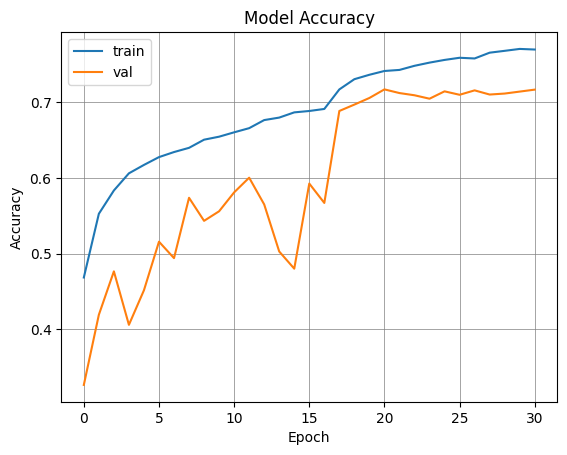

In [55]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.legend(['train', 'val'], loc='upper left')

# path
path = f"logs/{output_date}_model_training_results"
if not os.path.isdir(path):
    os.makedirs(path)
    plt.savefig(f"{path}/acc_plot.jpg")
    plt.show()

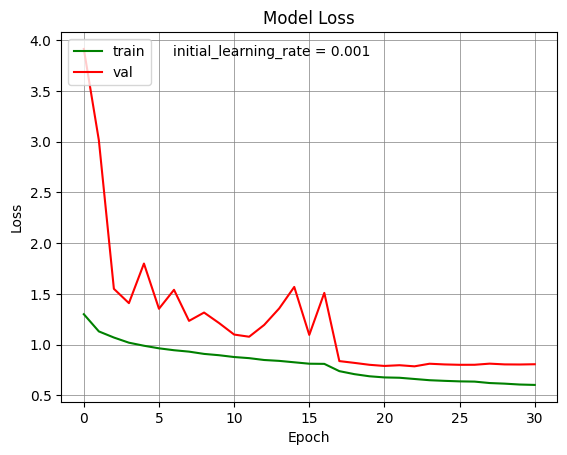

In [56]:
# summarize history for loss
plt.plot(history.history['loss'], color='green')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.figtext(0.30, 0.83, f'initial_learning_rate = {INITIAL_LEARNING_RATE}')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.legend(['train', 'val'], loc='upper left')

# path
path = f"logs/{output_date}_model_training_results"
if os.path.isdir(path):
    plt.savefig(f"{path}/loss_plot.jpg")
    plt.show()

### Saving model configuration and hyperparameters values to json file

In [57]:
with open(f"{path}/{output_date}_model_configuration.json", "w") as json_file:
    json.dump(model_configuration, json_file)

In [58]:
json_string = model.to_json()
with open(f"{path}/{output_date}_model_architecture.json", "w") as model_architecture_json:
    model_architecture_json.write(json_string)

---

## Load Model For Evaluation and Prediction

In [63]:
# Return images and labels normalized and gray scaled
# X -> numpy array images
# y -> string classes labels
X_test, y_test = read_dataset(
    path='faces/test',
    angry=59,
    fear=52,
    happy=35,
    neutral=69,
    sad=42,
)

  7%|████████                                                                                                             | 42/609 [00:00<00:01, 323.08it/s]

sum of images: 257


In [64]:
X_test.shape

(257, 224, 224, 3)

In [65]:
# shuffle data to avoid bias and improve generalization
X_test, y_test = shuffle(X_test, y_test, random_state=42)
print(X_test.shape, y_test.shape)

(257, 224, 224, 3) (257,)


In [66]:
# normalize data
print(X_test.max())
X_test = X_test / 255.0
print(X_test.max())

255
1.0


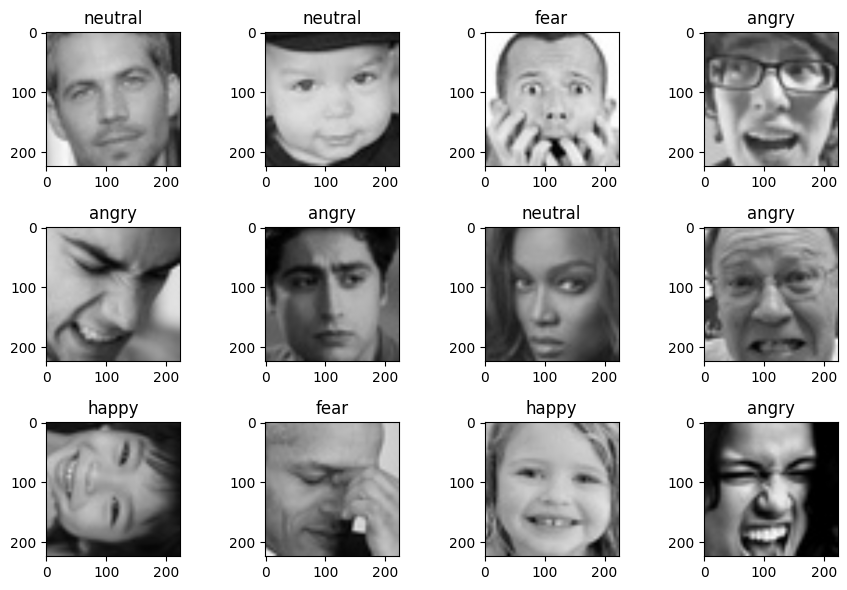

In [67]:
dataset_visualization(X_test, y_test)

In [68]:
# some samples
y_test[:10]

array(['neutral', 'neutral', 'fear', 'angry', 'angry', 'angry', 'neutral',
       'angry', 'happy', 'fear'], dtype='<U7')

In [69]:
# reshape the y_test array from 1D to 2D array
y_test_reshaped = y_test.reshape(-1, 1)
y_test_reshaped[:10]

array([['neutral'],
       ['neutral'],
       ['fear'],
       ['angry'],
       ['angry'],
       ['angry'],
       ['neutral'],
       ['angry'],
       ['happy'],
       ['fear']], dtype='<U7')

In [70]:
# transform 2D y_train to onehot encoding
# instantiate the OneHotEncoder classs
encoder = OneHotEncoder(sparse_output=False)
y_test_onehot = encoder.fit_transform(y_test_reshaped)

In [71]:
y_test_onehot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [72]:
new_model = tf.keras.models.load_model("saved_models/model-21-0.7172.h5")

In [73]:
score = new_model.evaluate(X_test, y_test_onehot)
score

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.5744 - loss: 1.1286


[1.1358448266983032, 0.5836575627326965]

In [74]:
print("Test loss:" , score[0])
print("Test accuracy", score[1])

Test loss: 1.1358448266983032
Test accuracy 0.5836575627326965


In [75]:
pred = new_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step


In [76]:
pred.shape

(257, 5)

In [77]:
pred_argmax = np.argmax(pred, axis=1) # get the first 5 max argument from pred array
pred_argmax[:5]

array([3, 3, 1, 2, 0])

In [78]:
label_argmax = np.argmax(y_test_onehot, axis=1)
label_argmax[:5]

array([3, 3, 1, 0, 0])

In [79]:
cm = confusion_matrix(label_argmax, pred_argmax)
cm

array([[32,  6,  6,  6,  9],
       [ 6, 28,  6,  4,  8],
       [ 1,  0, 30,  4,  0],
       [ 3,  5, 10, 40, 11],
       [ 4,  4,  0, 14, 20]])

In [80]:
print(classification_report(label_argmax, pred_argmax))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        59
           1       0.65      0.54      0.59        52
           2       0.58      0.86      0.69        35
           3       0.59      0.58      0.58        69
           4       0.42      0.48      0.44        42

    accuracy                           0.58       257
   macro avg       0.59      0.60      0.58       257
weighted avg       0.60      0.58      0.58       257



In [81]:
def plot_cm_heatmap():
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        xticklabels=['angry', 'fear', 'happy', 'neutral', 'sad'],
        yticklabels=['angry', 'fear', 'happy', 'neutral', 'sad']
    )
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top')
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

    # path
    path_to = f"logs/{output_date}_model_training_results"
    if os.path.isdir(path_to):
        plt.savefig(f"{path_to}/confusion_matrix.jpg")
        plt.show()

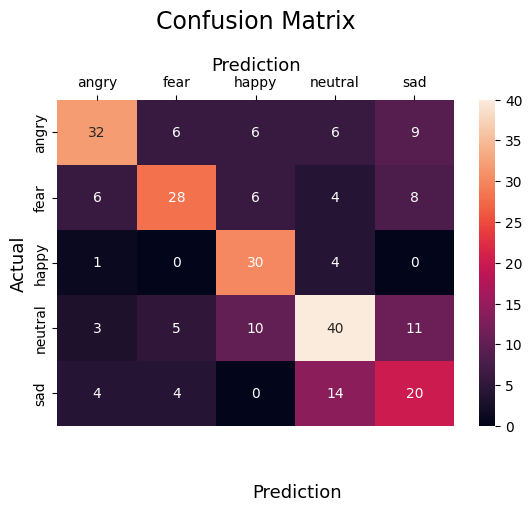

In [82]:
plot_cm_heatmap()

In [83]:
def plot_samples_pred(X_test, y_test, actual, prediction):
    # initial variables for figure
    rows = 5
    cols = 5
    # initiate the structure of the training and test folder class names
    class_names = ['angry', 'fear', 'happy', 'neutral', 'sad']
    # set initial parameters for figure
    fig = plt.figure(figsize=(7,8), layout="constrained")
    # iterate through the images and class names
    for i in range(0, rows*cols):
        fig.add_subplot(rows, cols, i+1)
        plt.xlabel(f"Actual: {y_test[actual[i]]}")
        if actual[i] == prediction[i]:
            plt.xlabel(f'Actual: {class_names[actual[i]]} \n Predicted: {class_names[prediction[i]]}', color='green')
        else:
            plt.xlabel(f'Actual: {class_names[actual[i]]} \n Predicted: {class_names[prediction[i]]}', color='red')
        plt.imshow(X_test[i], cmap='gray')
    # display grid of images
    fig.tight_layout()
    # path
    path_to = f"logs/{output_date}_model_training_results"
    if os.path.isdir(path_to):
        plt.savefig(f"{path_to}/predictions.jpg")
        plt.show()

In [84]:
print(y_test[:10])
print(label_argmax[:10])
print(pred_argmax[:10])

['neutral' 'neutral' 'fear' 'angry' 'angry' 'angry' 'neutral' 'angry'
 'happy' 'fear']
[3 3 1 0 0 0 3 0 2 1]
[3 3 1 2 0 0 3 4 3 2]


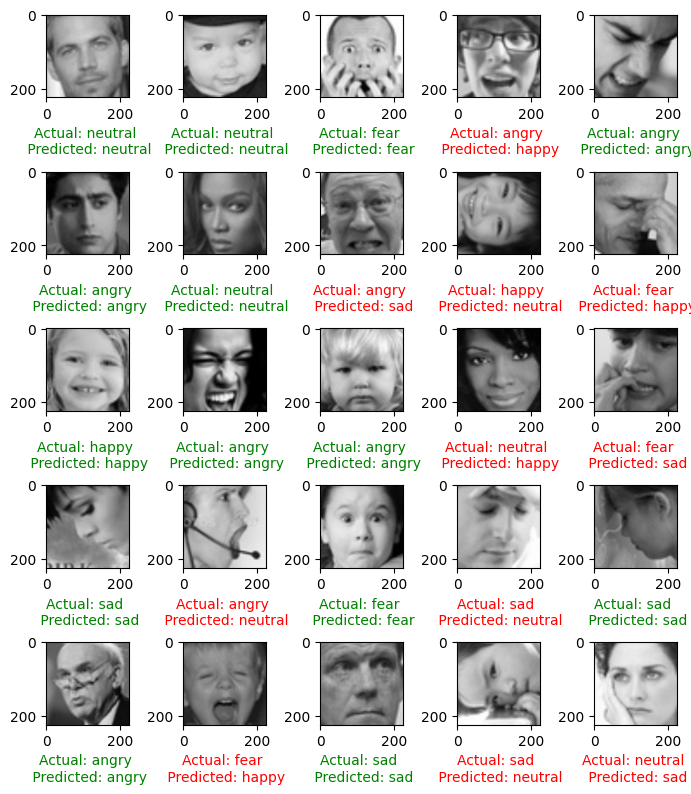

In [85]:
plot_samples_pred(X_test, y_test, label_argmax, pred_argmax)